# Mock Dataset

In [3]:
import pandas as pd
import random

def generate_mock_data(num_samples=1000):
    """
    Generate a mock dataset for caregiver interactions.
    Each row represents a simulated interaction.
    """
    data = []
    for _ in range(num_samples):
        # Randomly assign state components
        sentiment = random.choice([-1, 0, 1])  # Negative, Neutral, Positive
        time_of_day = random.choice([0, 1, 2])  # Morning, Evening, Night
        query_type = random.choice(["emotional", "practical", "mixed"])

        # Simulate agent actions and rewards
        if sentiment == -1:  # Caregiver is stressed
            action = random.choice([0, 2])  # Emotional or Mixed preferred
            reward = 2 if action == 0 else 1
        elif sentiment == 0:  # Caregiver is neutral
            action = random.choice([1, 2])  # Logical or Mixed preferred
            reward = 2 if action == 1 else 1
        else:  # Caregiver is positive
            action = random.choice([0, 1, 2])  # Any response is okay
            reward = 2 if action == random.choice([0, 1, 2]) else 1

        # Append row to dataset
        data.append([sentiment, time_of_day, query_type, action, reward])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Sentiment", "TimeOfDay", "QueryType", "Action", "Reward"])
    return df

# Generate and save mock data
mock_data = generate_mock_data(1000)
mock_data.to_csv("mock_caregiver_data.csv", index=False)
print("Mock dataset created and saved as 'mock_caregiver_data.csv'")


Mock dataset created and saved as 'mock_caregiver_data.csv'


# Creating Custom Environment

In [10]:
class CaregiverEnvWithDataset(gym.Env):
    def __init__(self, dataset_path):
        super(CaregiverEnvWithDataset, self).__init__()
        self.data = pd.read_csv(dataset_path)
        self.current_index = 0
        self.action_space = spaces.Discrete(3)  # Actions: Emotional, Logical, Mixed
        self.observation_space = spaces.Box(low=-1, high=2, shape=(3,), dtype=np.float32)

    def reset(self):
        # Reset to the first row of the dataset
        self.current_index = 0
        row = self.data.iloc[self.current_index]
        sentiment = row["Sentiment"]
        time_of_day = row["TimeOfDay"]
        last_action = -1  # No action yet
        self.current_state = np.array([sentiment, time_of_day, last_action], dtype=np.float32)
        return self.current_state

    def step(self, action):
        # Get current row from the dataset
        row = self.data.iloc[self.current_index]
        sentiment = row["Sentiment"]
        time_of_day = row["TimeOfDay"]
        reward = row["Reward"] if row["Action"] == action else -1  # Penalize mismatched actions

        # Update sentiment (simulate change)
        sentiment += np.random.uniform(-0.1, 0.2)  # Simulate small changes in sentiment
        sentiment = np.clip(sentiment, -1, 1)

        # Update state and index
        self.current_state = np.array([sentiment, time_of_day, action], dtype=np.float32)
        self.current_index += 1
        done = self.current_index >= len(self.data)

        return self.current_state, reward, done, {}

# Example usage
env = CaregiverEnvWithDataset("mock_caregiver_data.csv")
state = env.reset()




# Calculate reward function

In [5]:
def calculate_reward(sentiment, action, time_of_day):
    """
    Calculates the reward based on the sentiment, action taken, and time of day.
    """
    # Reward for matching response type to sentiment
    if action == 0 and sentiment == -1:  # Emotional support for negative sentiment
        reward = 2
    elif action == 1 and sentiment == 0:  # Logical response for neutral sentiment
        reward = 2
    elif action == 2:  # Mixed response for any sentiment
        reward = 1
    else:
        reward = -1  # Mismatched response

    # Additional reward for matching time-of-day context
    if time_of_day == 2 and action == 0:  # Nighttime prefers emotional responses
        reward += 1
    elif time_of_day == 0 and action == 1:  # Morning prefers logical responses
        reward += 1

    return reward

# Action selection

In [6]:
import random
import numpy as np
import torch

def select_action(state, q_network, epsilon, action_space_size):
    """
    Selects an action based on epsilon-greedy policy.
    """
    if random.random() < epsilon:  # Exploration
        return random.randint(0, action_space_size - 1)
    else:  # Exploitation
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        q_values = q_network(state_tensor)  # Predict Q-values
        return torch.argmax(q_values).item()


# DQN

In [7]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Output Q-values for each action


# Replay buffer stores past experience for training

In [8]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


# Training loop for DQN

Episode 0: Total Reward = 19
Episode 1: Total Reward = 26
Episode 2: Total Reward = 21
Episode 3: Total Reward = 24
Episode 4: Total Reward = 19
Episode 5: Total Reward = 36
Episode 6: Total Reward = 25
Episode 7: Total Reward = 27
Episode 8: Total Reward = 12
Episode 9: Total Reward = 16
Episode 10: Total Reward = 26
Episode 11: Total Reward = 38
Episode 12: Total Reward = 41
Episode 13: Total Reward = 38
Episode 14: Total Reward = 39
Episode 15: Total Reward = 20
Episode 16: Total Reward = 51
Episode 17: Total Reward = 41
Episode 18: Total Reward = 21
Episode 19: Total Reward = 17
Episode 20: Total Reward = 40
Episode 21: Total Reward = 28
Episode 22: Total Reward = 21
Episode 23: Total Reward = 34
Episode 24: Total Reward = 31
Episode 25: Total Reward = 43
Episode 26: Total Reward = 46
Episode 27: Total Reward = 41
Episode 28: Total Reward = 38
Episode 29: Total Reward = 7
Episode 30: Total Reward = 32
Episode 31: Total Reward = 29
Episode 32: Total Reward = 47
Episode 33: Total Rew

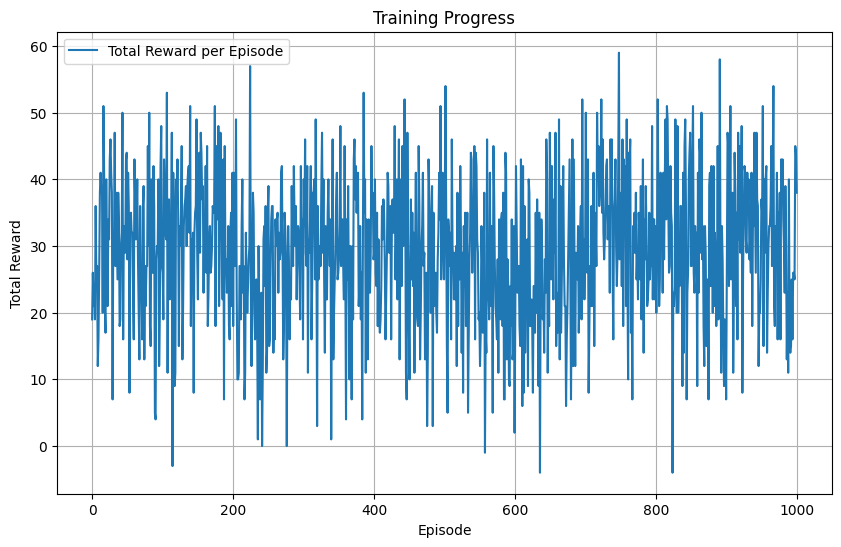

In [12]:
import matplotlib.pyplot as plt

# Initialize storage for rewards
episode_rewards = []

# Training loop
for episode in range(1000):  # Number of episodes
    state = env.reset()  # Reset environment
    total_reward = 0

    for t in range(100):  # Max steps per episode
        # Select action
        action = select_action(state, q_network, epsilon, action_dim)

        # Take action and observe transition
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, done))
        total_reward += reward

        # Train if replay buffer is ready
        if replay_buffer.size() >= batch_size:
            batch = replay_buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to tensors
            states_tensor = torch.tensor(states, dtype=torch.float32)
            actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
            next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
            dones_tensor = torch.tensor(dones, dtype=torch.float32)

            # Compute target Q-values
            with torch.no_grad():
                target_q_values = rewards_tensor + gamma * torch.max(target_network(next_states_tensor), dim=1)[0] * (1 - dones_tensor)

            # Compute current Q-values
            q_values = q_network(states_tensor).gather(1, actions_tensor).squeeze()

            # Compute loss
            loss = torch.mean((q_values - target_q_values) ** 2)

            # Optimize the network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update state
        state = next_state

        if done:
            break

    # Update epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Update target network periodically
    if episode % 10 == 0:
        target_network.load_state_dict(q_network.state_dict())

    # Log total reward for the episode
    episode_rewards.append(total_reward)

    print(f"Episode {episode}: Total Reward = {total_reward}")

# Plotting the rewards
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.show()

